


Cacophony Index 1.0 demo version!
It can be used to see the process while it's happening instead of behind that black terminal screen.
by Finbar Maunsell
This is a process with three main functions.
1. Voice detection - input: sound_file, output: voice timestamps 
2. Muting of voices - input: sound_file, timestamps, output: sound_file2 with muted voices
3. Birdsong(sound event) detection - input: sound_file2, output: score and a very useful graph

The voice detection algorithm uses the py-webrtcvad module to interact with the Google WebRTC Voice Activity Detector. 
This marks frames likely to have voice in the sound file. These frames are then muted by the mute_voices function. 
The VAD has aggressiveness settings (from 1-3, 3 being most aggressive and the default). This can be changed at detect_voices(). 

It is important to note that the sound files are manipulated as bytes until the mute_voices/mute_sections functions and from thereafter,
loaded as numpy arrays using the librosa library. 

Split_chunks, join_chunks, replace_small_chunks, get_optimal_chunks is an algorithm adopted from Kyle Mcdonalds work. It is best designed for
non-noisy audio files. I haven't done much work on it, more provided the grounds for improvement in the future. The algorithm 
is briefly explained in detect_events()

The final result of detect_events() is a score for the sound file being analysed. This is based on the total ### labelled as birdsong. 
There is also the option to save a graph showing the detected events. I suggest this is used to analyse the accuracy of the
scores 

You have the option of choosing to show_plots or save_samples which can both be used to analyse results. 

The process can be run on a single file or a folder of files. The files must be in wav or mp3.




In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
from matplotlib import patches

from random import shuffle
import os
from os.path import join
import collections#?
import contextlib
import sys
import wave
import webrtcvad

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

from IPython.display import display #?
from utils import list_all_files, ffmpeg_load_audio, ffmpeg_save_audio#?
import fnmatch



In [2]:
def list_all_files(directory, extensions=None):
    """little function for listing all files in a directory to use if you intend to run the index on multiple files"""
    for root, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            base, ext = os.path.splitext(filename)
            joined = os.path.join(root, filename)
            if extensions is None or ext.lower() in extensions:
                yield joined

def convert_file_format(path, int16_folder):
    """
    Load audio file (path) as a floating point time series. if the int16 folder is non existent then we create it! 
    convert to mono, int16, sr=16000, .wav and save it as path_int16 for use in vda
    path: path of original file
    int16_folder: folder where int16 files are held
    
    may have to include somehting like wf.setsampwidth(2) if sampwidth becomes an issue."""
    if not os.path.exists(int16_folder):
        os.makedirs(int16_folder)
    basename = os.path.basename(path).split('.')[0] 
    path_int16 = int16_folder + '/' + basename + '_int16' + '.wav'
    
    y, sr = librosa.load(path)
    y_mono = librosa.to_mono(y)
    target_sr = 16000
    y_resampled = librosa.core.resample(y, sr, target_sr)
    maxv = np.iinfo(np.int16).max
    librosa.output.write_wav(
        path_int16, (y_resampled * maxv).astype(np.int16), target_sr
    )
    return path_int16

def write_wave(path, audio, sample_rate):
    """Used to save the voice samples if save_samples is True"""
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)
        
def read_wave(path):
    """open wave and check it matches the requirements"""
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate

class Frame(object):
    """frame object to be used in vad collector"""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration

def frame_generator(frame_duration_ms, audio, sample_rate):
    """split audio (bytes) into frames"""
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0 #gets the duration of each sample to analyse, ie. 3ms
    while offset + n < len(audio):#go over all them 'samples' of '3ms'
        #create frame object to go into 'frames'
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n
        
def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    """this function starts off assuming no voice and if more than 9  frames in a row (assuming we leave frame
    durationa nd padding duration at 30, 300 - which i dont see any reason not to?) are marked as voiced then add those
    from the buffer (list of last ten frames) to the list of voiced frames and set triggered to true
    while triggered is true, add all frames to voiced frames until we meet ten unvoiced frames in a row. when that happens
    add the list of voiced frames to 'segments'(returned value), clear the buffer and set list of voiced frames back to 0. 
    Set triggered to false and begin from top again.
    At the end of it all we should have 'segments' which is a set of all the 'voiced' sections in the file.
    """
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)#just 300/30
    ring_buffer = collections.deque(maxlen=num_padding_frames)#so maxlen=10. max capacity=10
    triggered = False
    voiced_frames = []
    for frame in frames:
        if not triggered:
            ring_buffer.append(frame)
            num_voiced = len([f for f in ring_buffer
                              if vad.is_speech(f.bytes, sample_rate)])#get count of frames in ring buffer 
            #that would be marked as voice
            if num_voiced > 0.9 * ring_buffer.maxlen:
                #if 90% voiced then add buffer to voiced frames and clear deq
                triggered = True
                voiced_frames.extend(ring_buffer)#add ring buffer to voicedframes
                ring_buffer.clear()#clear ring buffer
        else:
            voiced_frames.append(frame)
            ring_buffer.append(frame)
            num_unvoiced = len([f for f in ring_buffer
                                if not vad.is_speech(f.bytes, sample_rate)])
            if num_unvoiced > 0.9 * ring_buffer.maxlen:#if maxlen = 10, then if 9 or 10 of the deque are unvoiced then change
                #triggered to false, return 'voiced_frames' to segments and clear the ring_buffer plus voiced_frames
                triggered = False
                yield [f for f in voiced_frames]
                ring_buffer.clear()
                voiced_frames = []
    if voiced_frames:
        yield [f for f in voiced_frames]

def detect_voices(path, convert=True, agg=3, save_samples=False, voices_folder='voices', int16_folder='int16'):
    """
    path: path for file to detect voices on. If not int16 then it must be converted as well
    convert: if this is True then convert the file to an int16 version and save in a specified folder 
    + run the rest of function using that file
    agg: the aggressiveness of the voice detection. 3 is most aggressive. I suggest 3 all the 
    time.(https://github.com/wiseman/py-webrtcvad)
    save_voices: if you want to save file of all voices to make sure they are actually voices
    voices_folder: where you want to save the tagged audio(voices)
    int16_folder: where you want to save the int16 version use for detecting voices
    """
    sys.stdout.write('detecting voices')
    

    if convert:
        #change path to path of converted file
        path = convert_file_format(path, int16_folder)
            
    audio, sample_rate = read_wave(path)
    vad = webrtcvad.Vad(int(agg))#https://github.com/wiseman/py-webrtcvad check that out
    
    frames = frame_generator(30, audio, sample_rate)
    frames = list(frames)#list of 3ms frames
    
    segments = vad_collector(sample_rate, 30, 300, vad, frames)
    
    bytes = b''
    timestamps = []
    for segment in segments:
        timestamps.append([segment[0].timestamp, segment[-1].timestamp])
        if save_samples:
            for s in segment:
                bytes += s.bytes
    
    if save_samples:
        if not os.path.exists(voices_folder):
            os.makedirs(voices_folder)
        
        basename = os.path.basename(path).split('.')[0] 
        voices_path = voices_folder + '/' + basename + '_voices.wav'
        write_wave(voices_path, bytes, sample_rate)#voices can be used to listen to the 'tagged audio'
    
    return timestamps

    

In [3]:
def mute_voices(path, timestamps, sr=48000, mute_agg=3, show_plots=False, voice_scrubbed_folder='voice_scrubbed', graphs_folder='graphs'):
    """handle the muting process and also create waveform graph to show muted areas if plot is True
    path: file path for audio file where we want to mute voice
    timestamps: sections marked as having voice by detect_voice()
    sr: sample rate. 
    voice_scrubbed_folder: folder where muted files are placed to then be used by detect_events()
    mute_agg: aggressiveness, how many seconds on each side of the timestamps we want to mute. Suggested >=3
    save_plot: whetehr or not you want to plot the graphs
    graphs_folder: where graphs are saved"""
    
    sys.stdout.write('\nmuting voices')
    
    y, _ = librosa.load(path, sr=sr)
    
    basename = os.path.basename(path).split('.')[0] 
        

    if show_plots:
        if not os.path.exists(graphs_folder):
            os.makedirs(graphs_folder)
        #plot non voice_scrubbed graph
        figsize = (30,6)
        time = np.linspace(0, len(y)/sr, num=len(y))
        plt.figure(figsize=figsize)
        plt.plot(time, y)
        plt.xlim([0, time[-1]])
        title = basename + ' ' + str(len(y)/sr) + 'seconds' + '\n' + 'NON-VOICE_SCRUBBED amplitude over time'
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.suptitle(title, fontsize=20)
        
        plt.show()
        
        plt.close()


    y_muted = mute_sections(y, timestamps, sr, mute_agg)

    if show_plots:
        #plot muted graph
        figsize = (30,6)
        time=np.linspace(0, len(y_muted)/sr, num=len(y_muted))
        plt.figure(figsize=figsize)
        plt.plot(time, y_muted)
        plt.xlim([0, time[-1]])
        title = path + ' ' + str(len(y_muted)/sr) + 'seconds' + '\n' + 'VOICESCRUBBED amplitude over time'
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.suptitle(title, fontsize=20)
        for left, right in timestamps:
            left = left-mute_agg
            right = right+mute_agg
            plt.gca().add_patch(patches.Rectangle((left, 0), (right - left), 1,
                                                hatch='vv', alpha=0.2, fill='black'))
            
        plt.show()
        plt.close()
    
    if not os.path.exists(voice_scrubbed_folder):
         os.makedirs(voice_scrubbed_folder)
    new_path = voice_scrubbed_folder + '/' + basename + '_scrubbed' + '.wav'
    librosa.output.write_wav(new_path, y_muted, sr)


def mute_sections(y, timestamps, sr, mute_agg):
    """mute the sections that have voice in them. These are marked by the timestamps
    y: audio as floating point series
    timestamps: sections marked as having voice by detect_voice()
    sr: sample rate
    mute_agg: aggressiveness, how many seconds on each side of the timestamps we want to mute. Suggested >=3
    
    return muted floating point series
    """
    y_muted = y.copy()
    for left, right in timestamps:
        left_byte_index = sr*(left-mute_agg)
        right_byte_index = sr*(right+mute_agg)
        no_voice_bytes = len(y_muted[int(left_byte_index):int(right_byte_index)])
        for sample in range(no_voice_bytes):
            y_muted[int(left_byte_index) + sample] = 0
    return y_muted

In [4]:
def split_chunks(x):
    """split x into lists(chunks) according to Bool val. Ie. [T, T, F, T, T] -> [[T, T], [F], [T, T]]
    This allows for use in get_optimal_chunks()"""
    chunks = []
    previous = None
    for sample in x:
        if sample != previous:
            chunks.append([])
        chunks[-1].append(sample)
        previous = sample
    return chunks

def join_chunks(chunks):
    """empty all chunks out of their sub-lists to be split apart again by split_chunks(). this is because chunks now
    looks like this [[t,t,t],[t,t],[f,f,f,][t]]"""
    return [item for sublist in chunks for item in sublist]

def replace_small_chunks(chunks, search, substitute, min_length):
    """change chunks to T/F if they're < min_length. ie. min_length =2: 
    [[t,t],[f],[t,t],[f,f]]->[[t,t][t][t,t][f,f]]). """
    modified = []
    for chunk in chunks:
        cur = chunk[0]
        if cur == search and len(chunk) < min_length:
            cur = substitute
        modified.append([cur for x in chunk])
    return split_chunks(join_chunks(modified))


def get_optimal_chunks(chunks, min_length=3, max_length=500, n=10):
    """ do a grid search to determine the min and max chunk sizes
    that minimize standard deviation of chunk lengths
    will always start by replacing F with T chunks."""
    best_std = None
    best_chunks = []
    for quiet_thresh in np.linspace(min_length, max_length, n):
        for sound_thresh in np.linspace(min_length, max_length, n):
            cur = replace_small_chunks(chunks, False, True, quiet_thresh)
            cur = replace_small_chunks(cur, True, False, sound_thresh)
            chunk_lengths = [len(chunk) for chunk in cur]
            cur_std = np.std(chunk_lengths)
            if (best_std is None or cur_std < best_std) and len(cur) > 1:
                #print cur_std, 'better than', best_std, 'using', quiet_thresh, sound_thresh
                best_chunks = cur
                best_std = cur_std
    return best_chunks

def save_birdsong_samples(samples, basename, sr, samples_folder):
    """from experience it is best to split smaples into 4 before saving them to avoid memory error on >=8gbram.
    """
    A1 = samples[:len(samples)/2]
    A2 = samples[len(samples)/2:]
    B1 = A1[:len(A1)/2]
    B2 = A1[len(A1)/2:]
    C1 = A2[:len(A2)/2]
    C2 = A2[len(A2)/2:]
    B1 = np.array(B1)
    C1 = np.array(C1)
    B2 = np.array(B2)
    C2 = np.array(C2)
    sample_path = samples_folder+ '/' + basename + 'sample'
    librosa.output.write_wav(sample_path+'.wav', B1, sr)
    librosa.output.write_wav(sample_path+'.wav', C1, sr)
    librosa.output.write_wav(sample_path+'.wav', B2, sr)
    librosa.output.write_wav(sample_path+'.wav', C2, sr)
    #ffmpeg_save_audio(samples_folder+ '/' + basename + 'sample1.wav', B1, sr=sr)
    
def detect_events(path, sr=48000, time_range=(0.05, 5), threshold_amp=0.3, n_fft=2048, 
                  save_samples=False, samples_folder='birdsong', plots_folder='plots', show_plots=False):
    """
    Convert time-series waveform to rmse(root mean squared energy) array. Perform normalisation on array. 
    Convert values in array to True/False if above/below threshold amp. 
    Send array to split_chunks which will create chunks based on series of subsequent T/F. get_optimal_chunks will
    standardize these chunks lengths resulting in the most 'birdsong' like sound events being labelled. 
    Once we have optimised the chunks we proceed to plot the rmse waveform. Those 'True' chunks that aren't
    too long will be labelled on the waveform plot as 'sound events' and contribute to the final 'score'.
    The final score is a measure of the amount of ####(samples?) that were labelled as birdsong.
    
    Because we expect the majority of sound events to be birdsong, we expect the majority of 
    sound events that are marked to also be birdsong. 
    
    path: file path for audio file where we want to detect events
    sr: sample rate. 
    time_range: a tuple with the min and max duration for sound events
    n_fft:number of samples in an analysis window (or frame). havent changhed this once. I assume it wont have an effect.
    threshold_amp: the minimum amp at which a sound event is marked before going through the algorithm.
    save_samples: if you want to save all the 'events' in files to listen to set it to True. I found these weren't as illuminating as 
    listening to path file while watching the graph. 
    samples_file: where the samples are saved. this is defaulted to a file in finns tree './sound/samples/
    grpahs folder: where you store graphs
    """
    sys.stdout.write('\nDetecting birds singing')
    hop_length = n_fft/4
    min_duration = time_range[0]
    max_duration = time_range[1]
    
    min_duration_frames = librosa.core.time_to_frames([min_duration], sr=sr, hop_length=hop_length)[0]
    max_duration_frames = librosa.core.time_to_frames([max_duration], sr=sr, hop_length=hop_length)[0]
    plot_downsample = 100
    figsize = (30,6)

    basename = os.path.basename(path).split('.')[0] 
    
    y, _ = librosa.load(path, sr)
    y /= y.max()
     
    # compute the rmse
    e = librosa.feature.rmse(y=y)[0]
    e -= e.min()#what does this really do, guessing a kind of normalisation?
    e /= e.max()
    
    et = np.where(e < threshold_amp, False, True)#threshold amp is usually set to around 0.3.

    # split the thresholded audio into chunks and combine them optimally
    chunks = split_chunks(et)
    chunks = get_optimal_chunks(chunks, min_duration_frames, max_duration_frames, 10)
    et = join_chunks(chunks)
    
    if show_plots:
        if not os.path.exists(plots_folder):
            os.makedirs(plots_folder)
        # plot the rmse and thresholded rmse
        plt.figure(figsize=figsize)
        plt.plot(e)
        plt.plot(et)
        title = basename + ' ' + str(len(y)/sr) + 'seconds' + '\n' + 'BIRDSONG DETECTED Root-mean-square-energy'
        plt.xlabel('Time')
        plt.ylabel('RMS Energy')
        plt.suptitle(title, fontsize=20)

    # convert chunks into "slices": beginning and end position pairs used for applying chunks to the actual data. we already have the iumportant fdata
    slices = []
    cur_slice = 0
    for chunk in chunks:
        next_slice = cur_slice + len(chunk)
        if chunk[0] and len(chunk) < max_duration_frames:
            slices.append([cur_slice, next_slice])
        cur_slice = next_slice
        
    samples = []
    total_event_duration = 0
    for left, right in slices:
        #is right - left the no. of ms in the slice? I'm pretty sure...
        total_event_duration += (right-left)
        if show_plots:
            # highlight saved chunks ie. the bits with birdsong
            #these will also be used to create the 'score'
            plt.gca().add_patch(patches.Rectangle((left, 0), (right - left), 1,
                                                 hatch='//', alpha=0.2, fill='black'))

        if save_samples:
            #we want to save the samples to listen to them
            sample = np.copy(y[left*hop_length:right*hop_length])
            sample /= np.abs(sample).max()
            for s in sample:
                samples.append(s)
    if save_samples:       
        if not os.path.exists(samples_folder):
            os.makedirs(samples_folder)
        save_birdsong_samples(samples, basename, sr, samples_folder)

    if show_plots:
        # finish up the plot to show birdsong we've been building
        plt.xlim([0, len(e)])
        plt.show()
        plt.close()
        
    return total_event_duration

I've provided cells for running the Index on both singular and multiple files.
Scores is a dictionary which holds all the scores(value) for each file(key).
use 'print scores' to see them.

detecting voices
muting voices

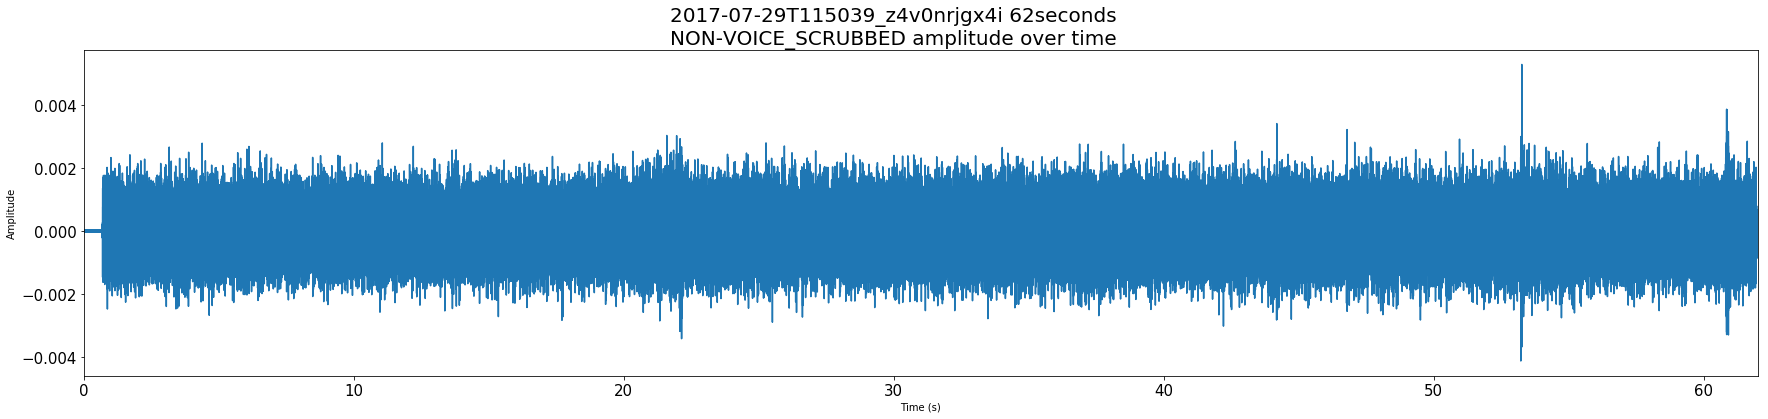

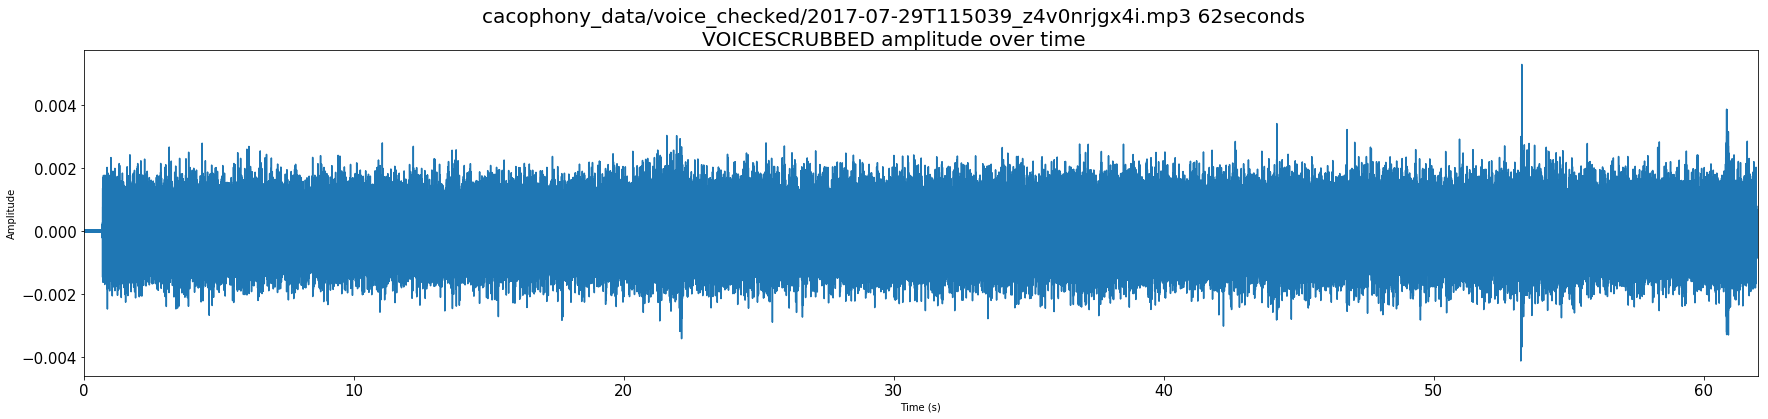


Detecting birds singing

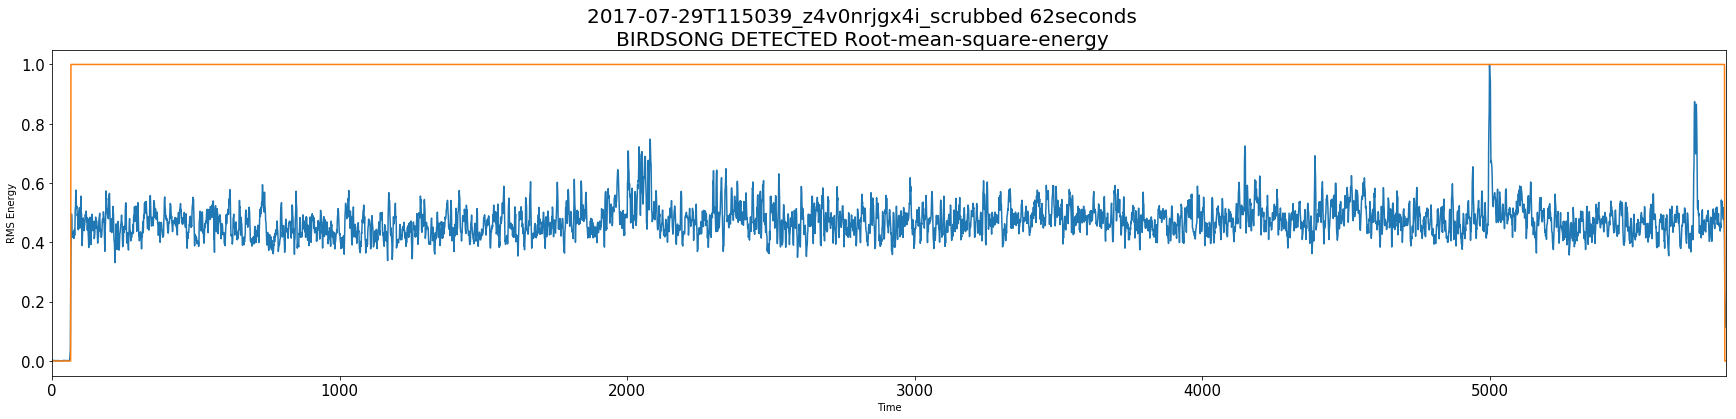

detecting voices
muting voices

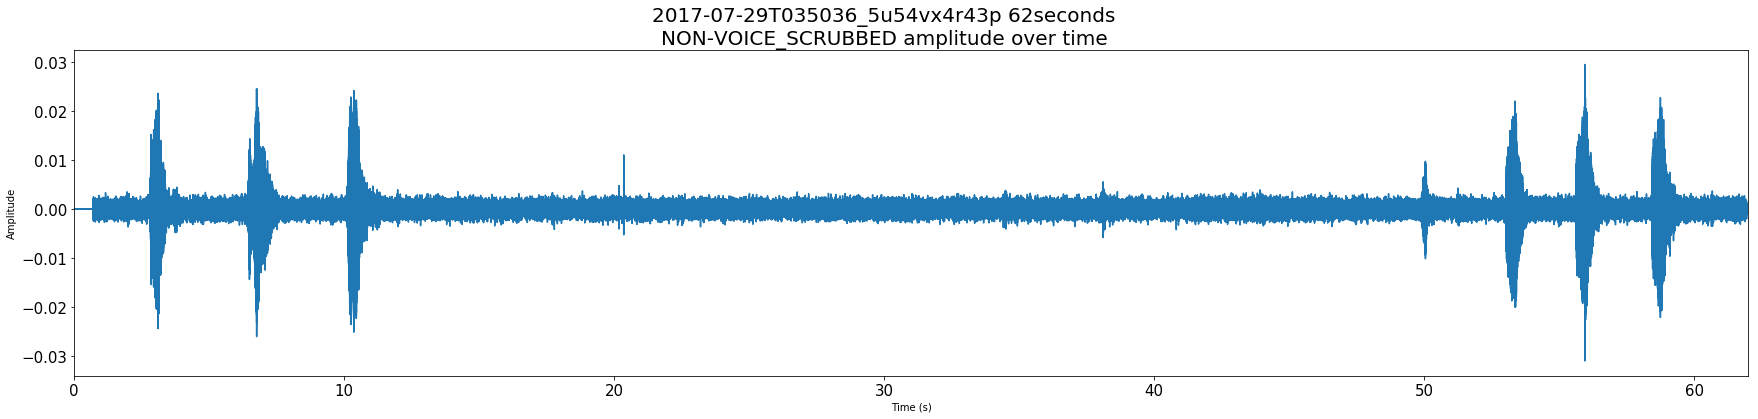

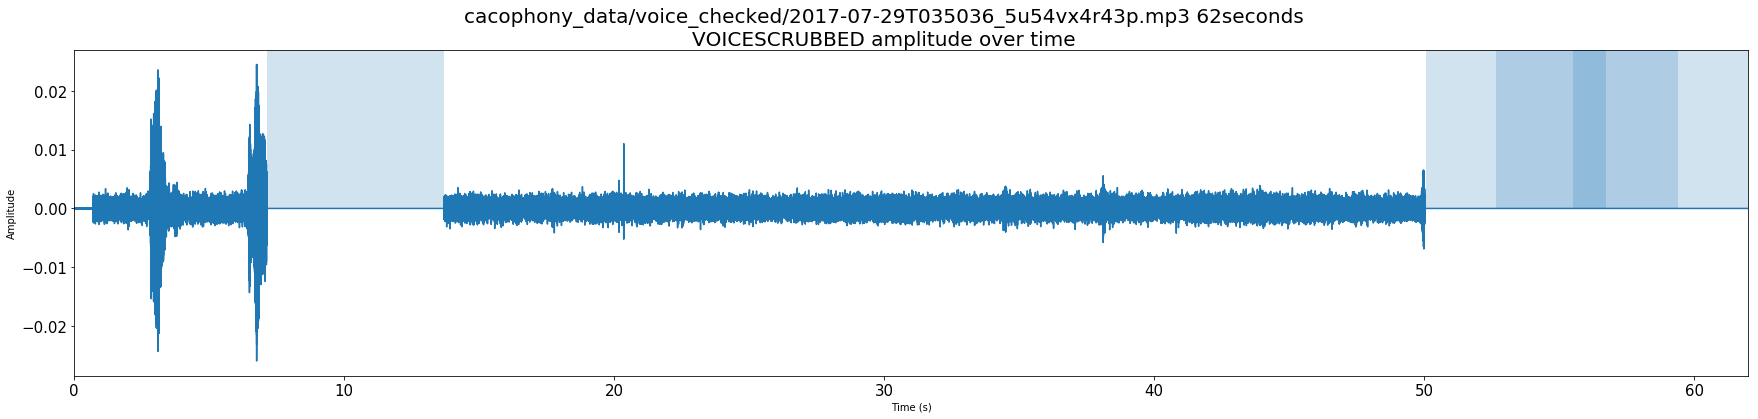


Detecting birds singing

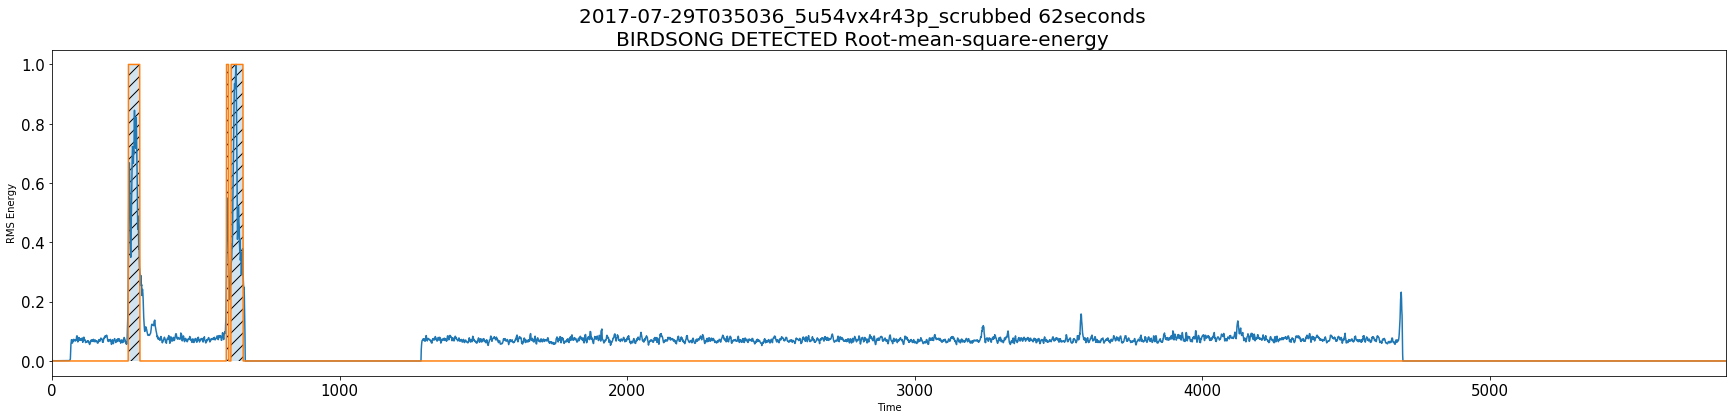

detecting voices
muting voices

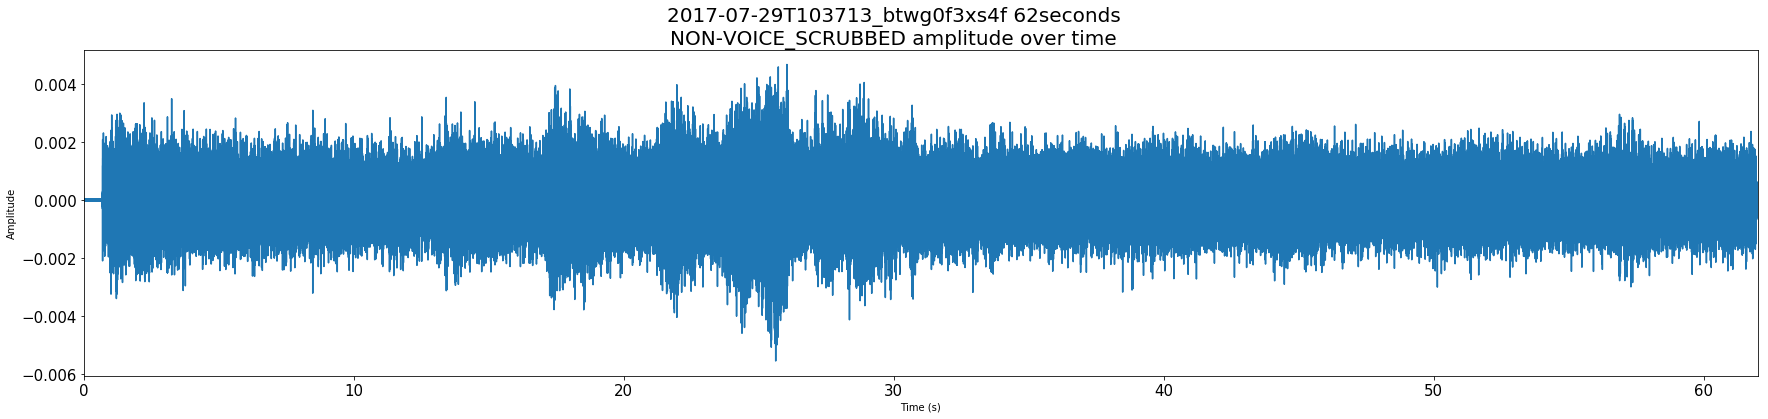

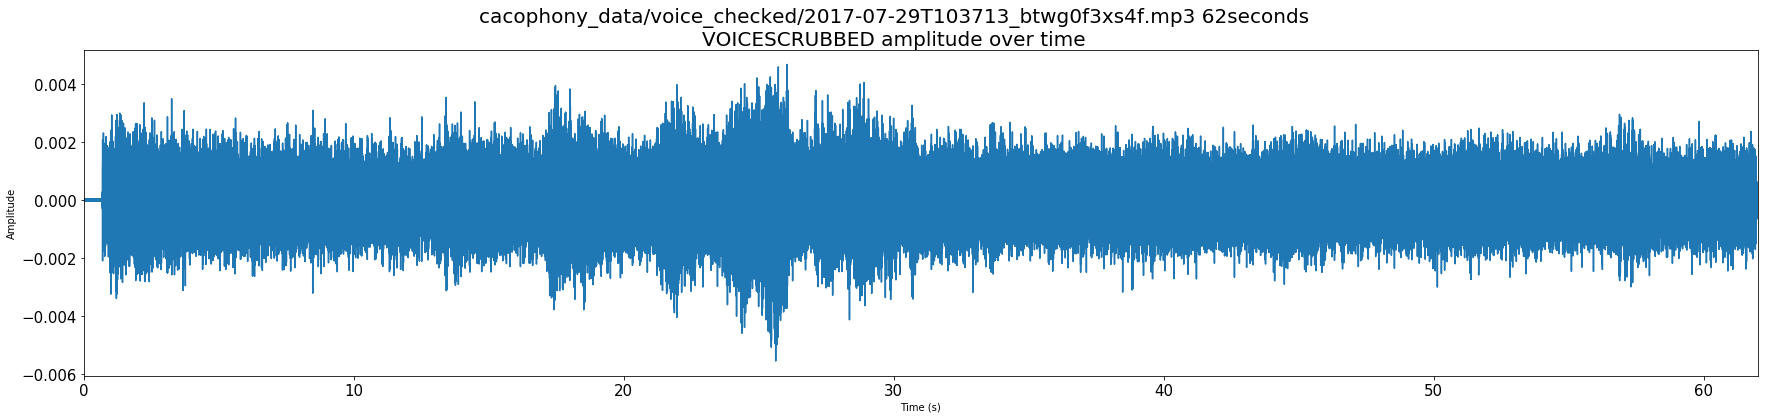


Detecting birds singing

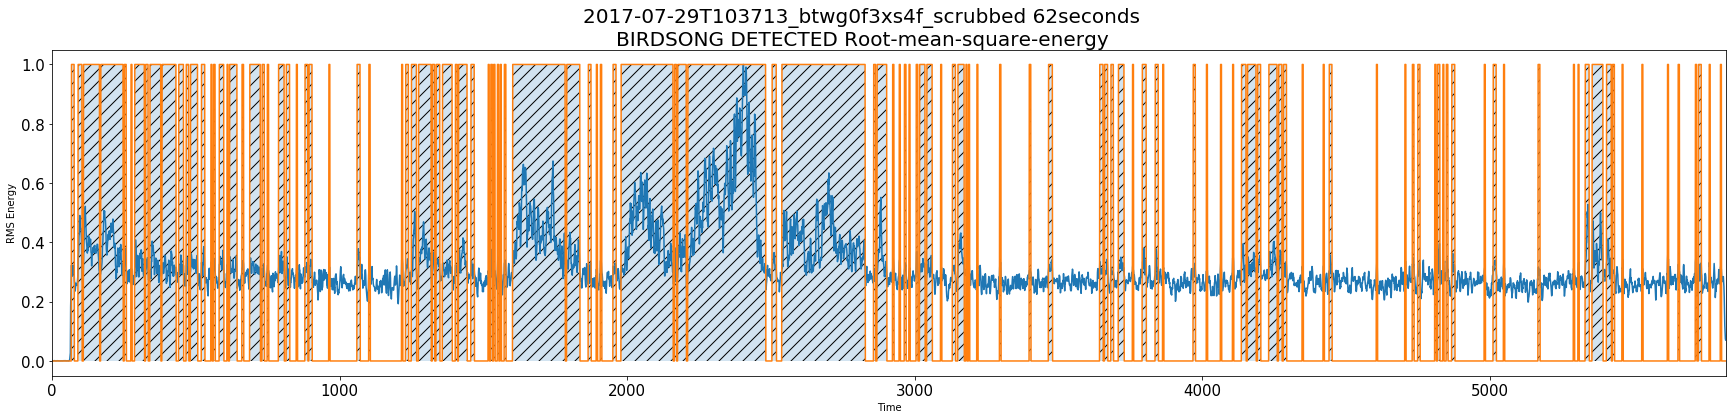

detecting voices
muting voices

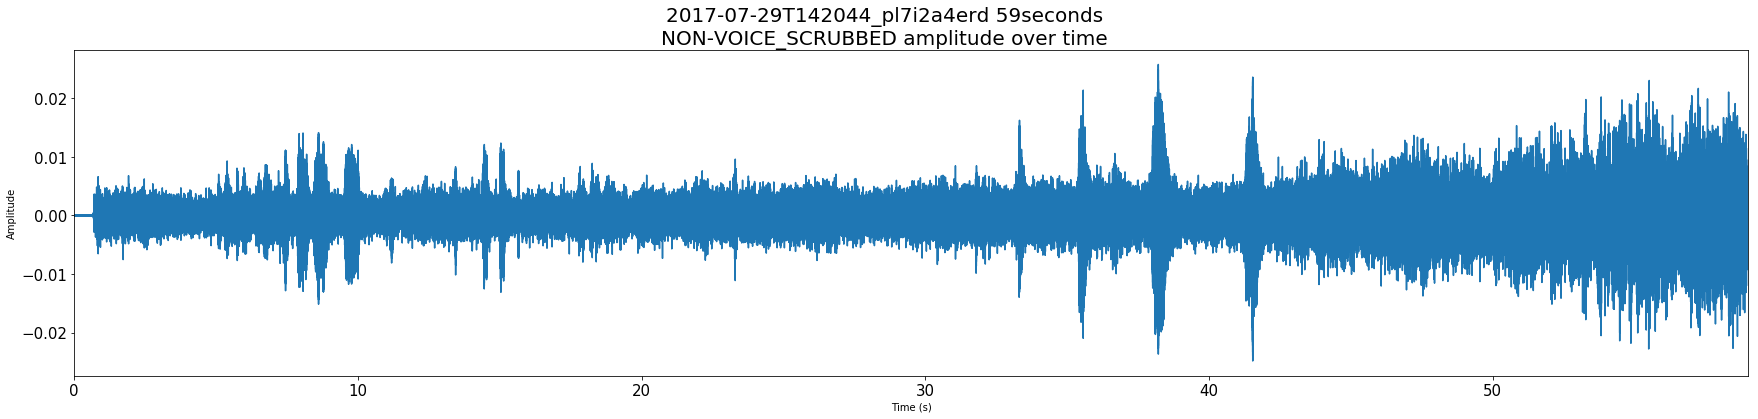

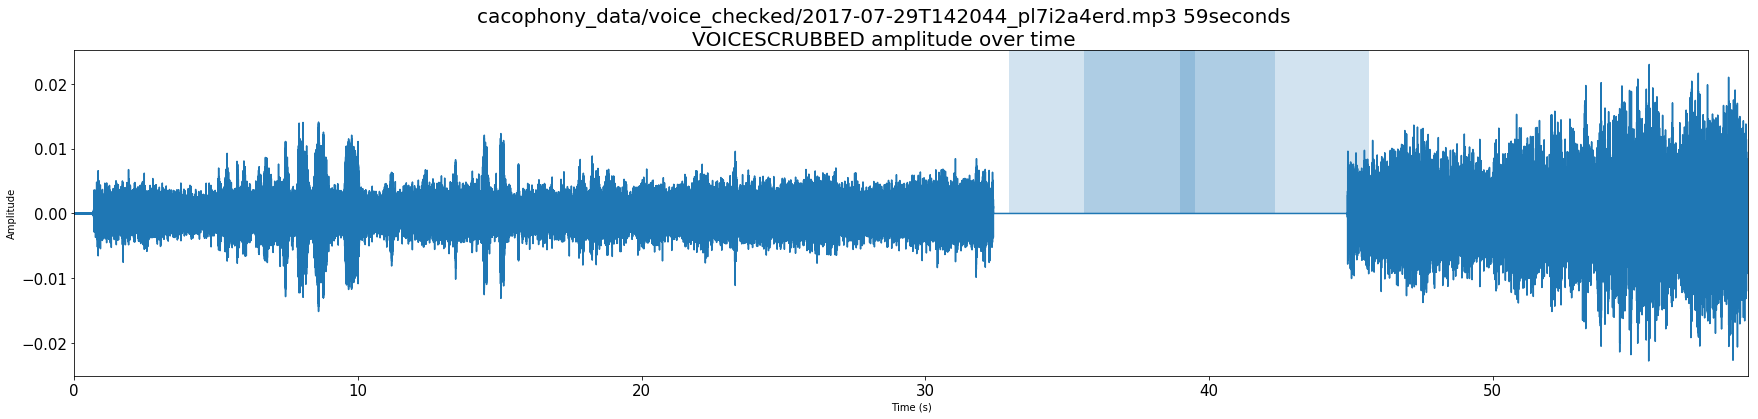


Detecting birds singing

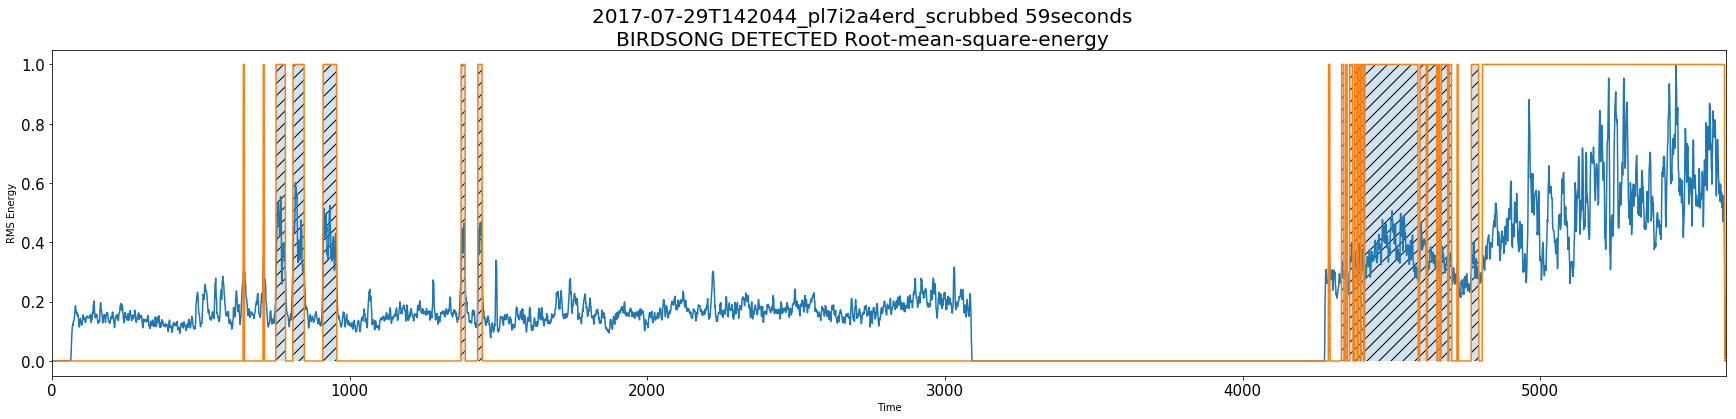

detecting voices
muting voices

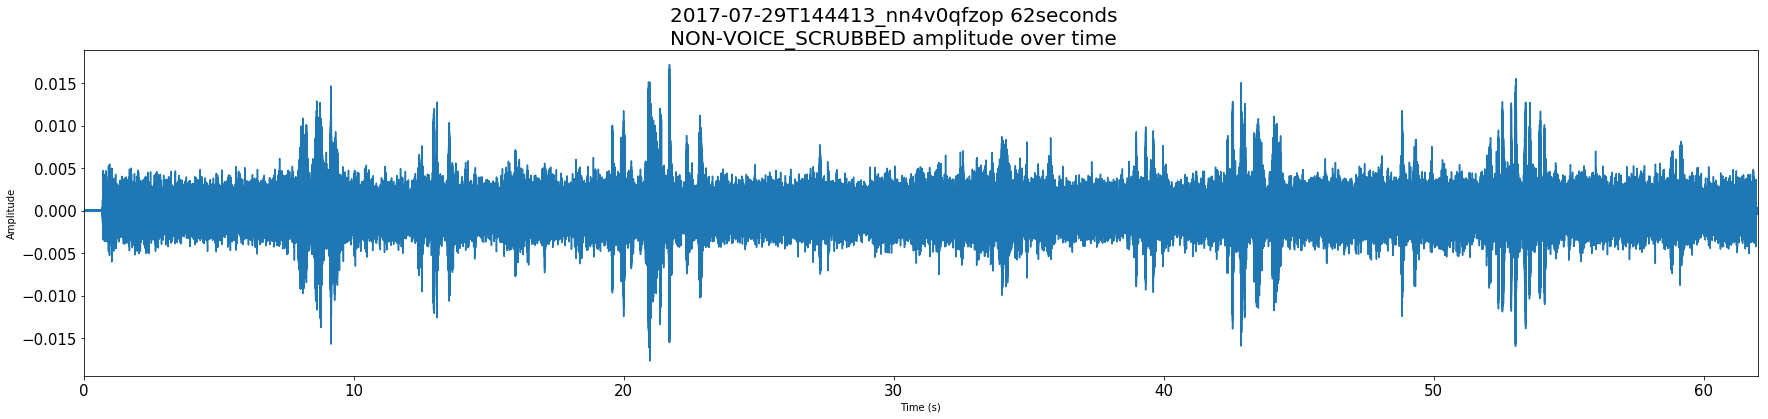

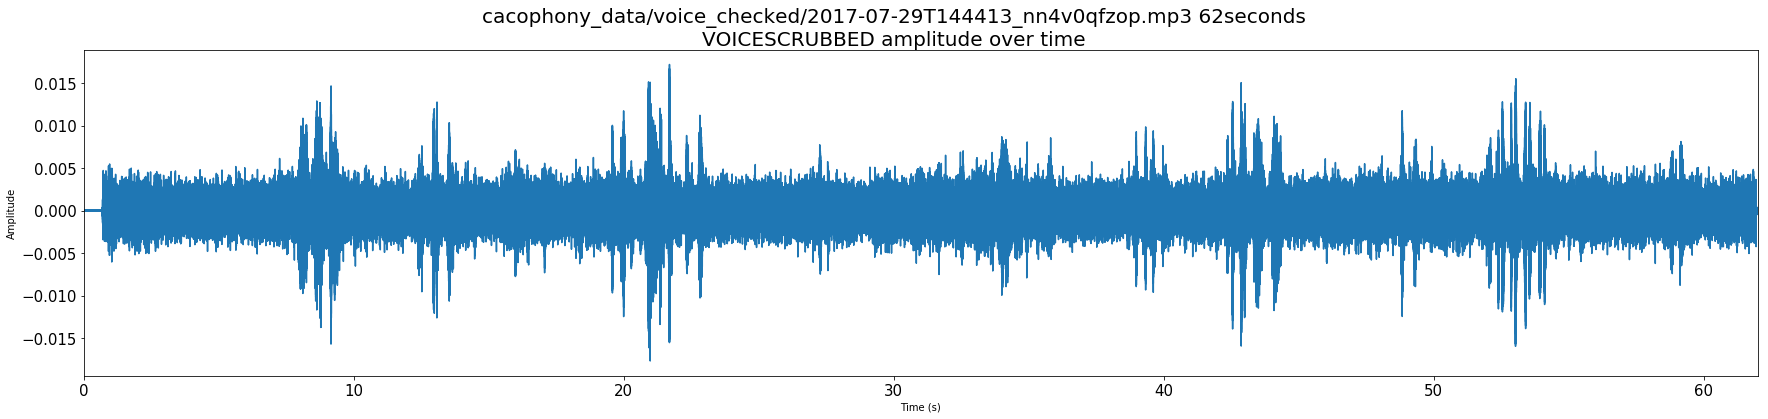


Detecting birds singing

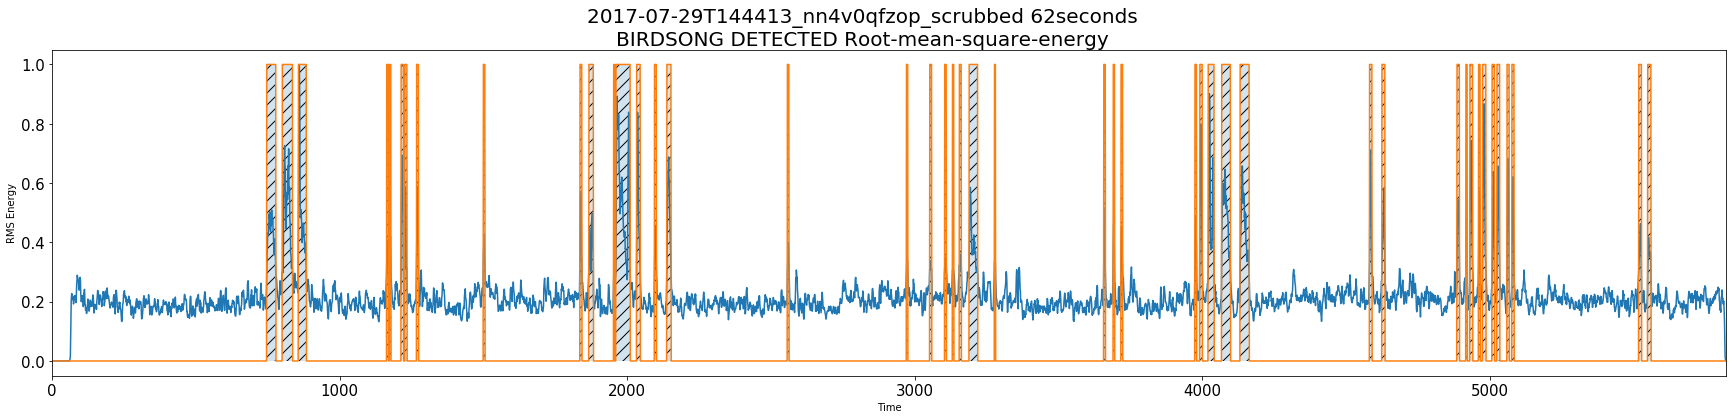

detecting voices
muting voices

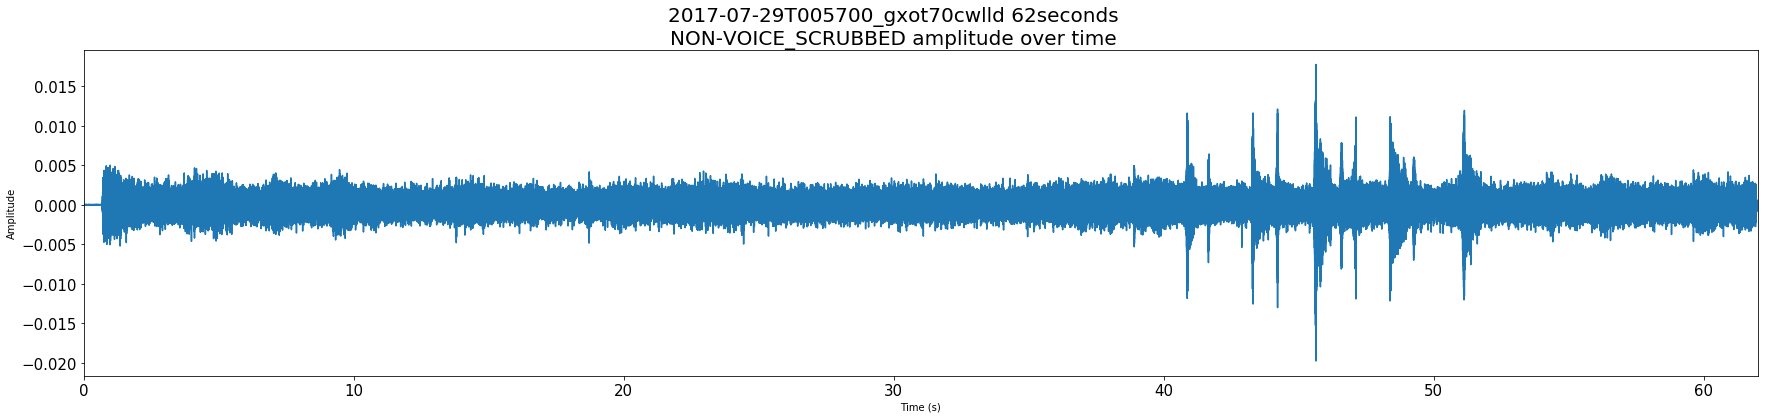

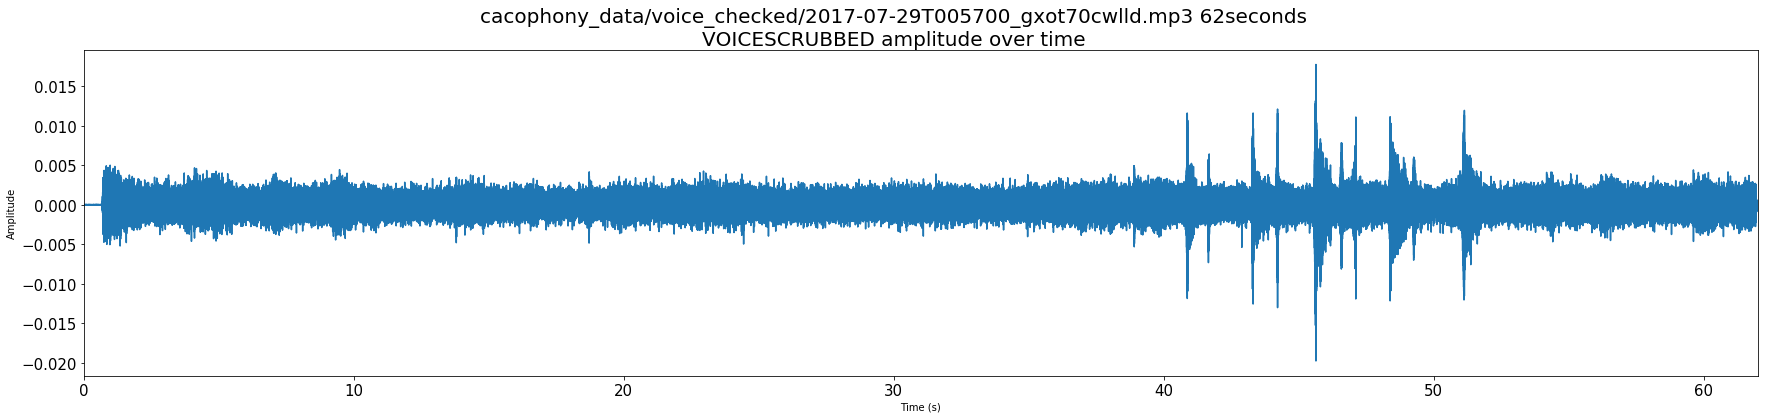


Detecting birds singing

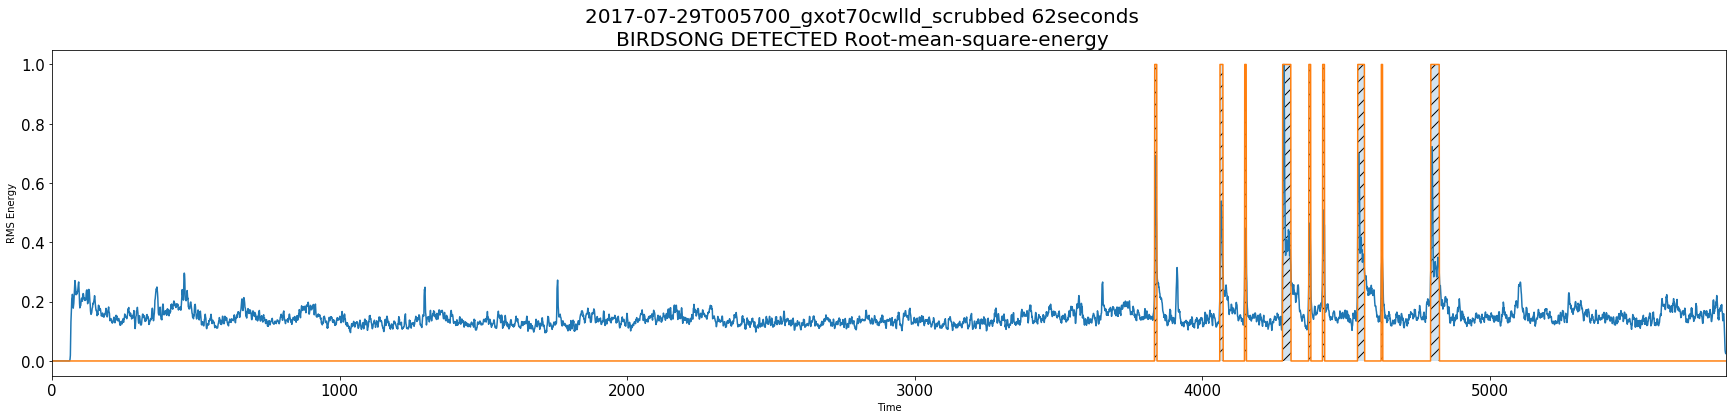

detecting voices
muting voices

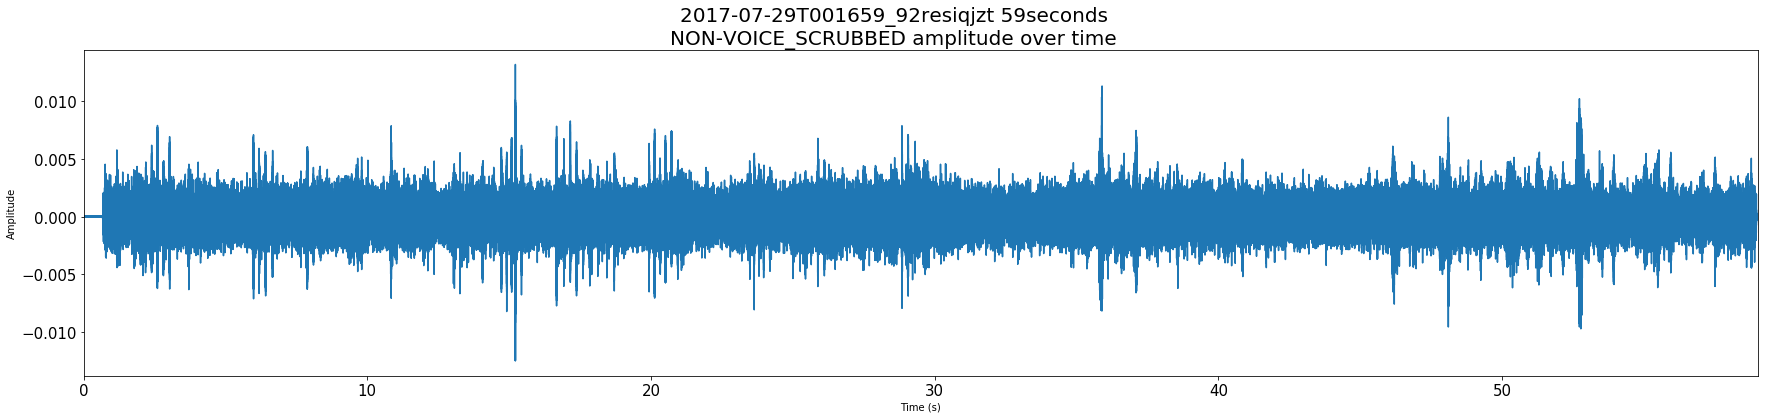

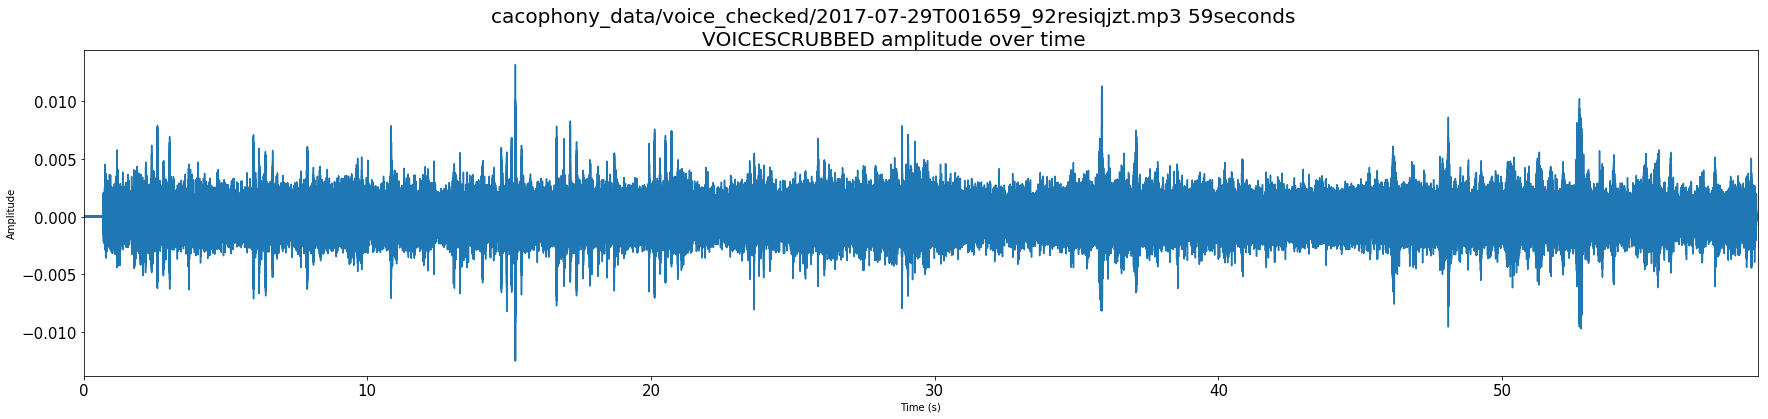


Detecting birds singing

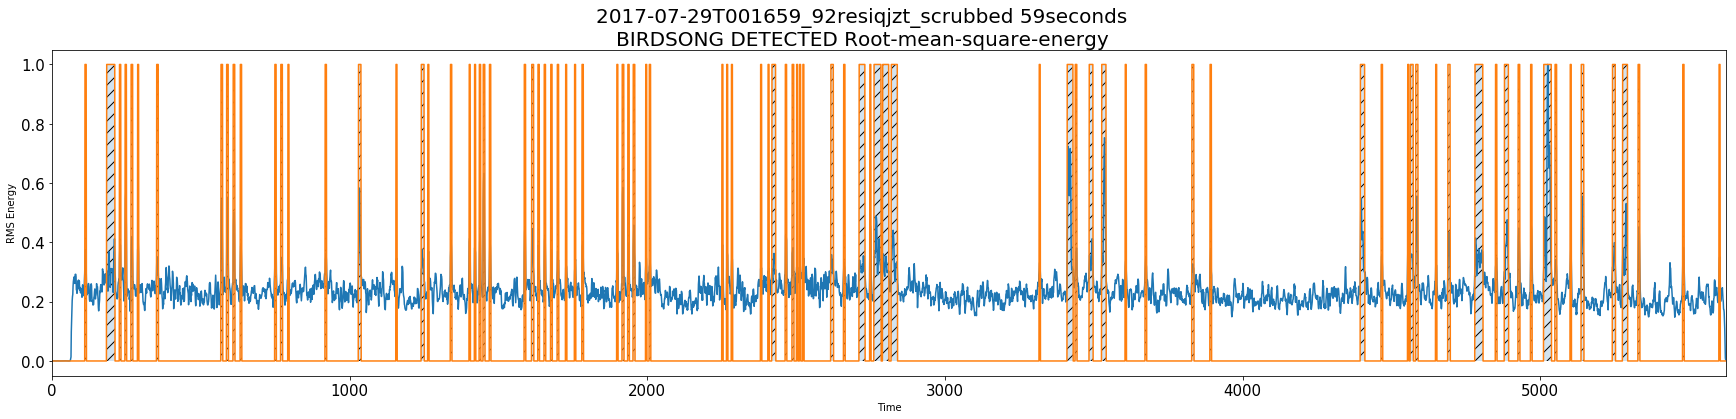

detecting voices
muting voices

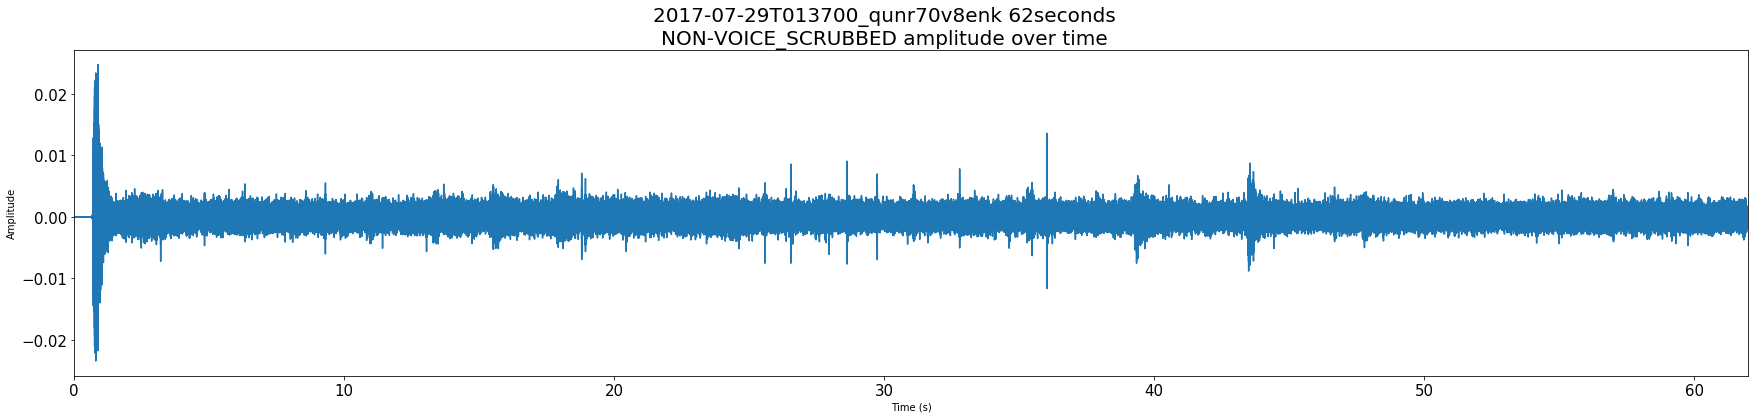

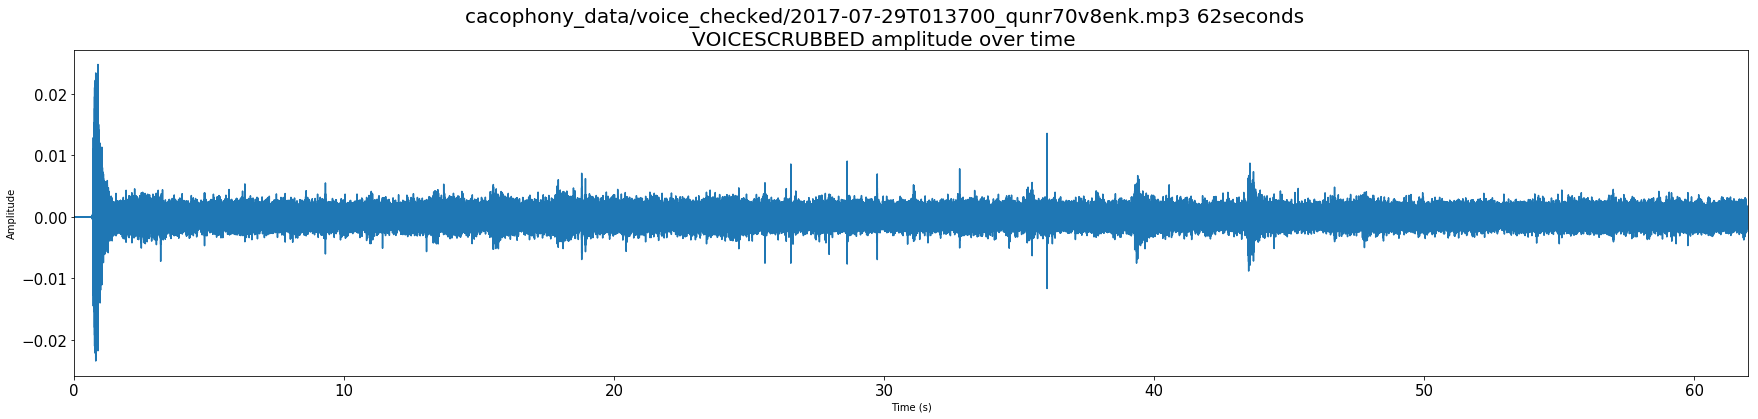


Detecting birds singing

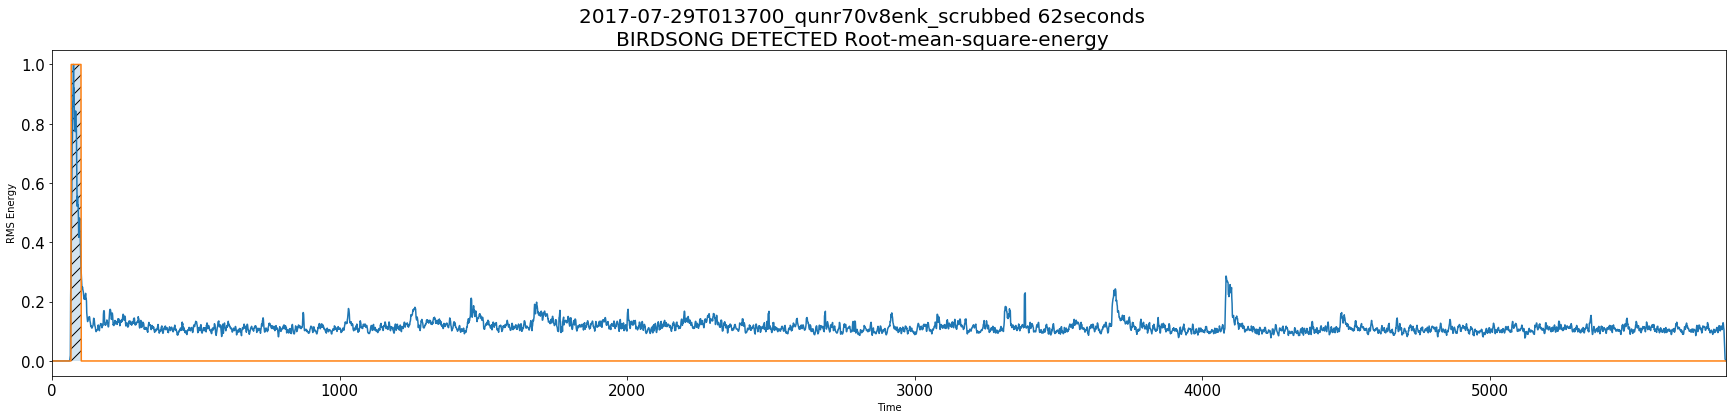

detecting voices
muting voices

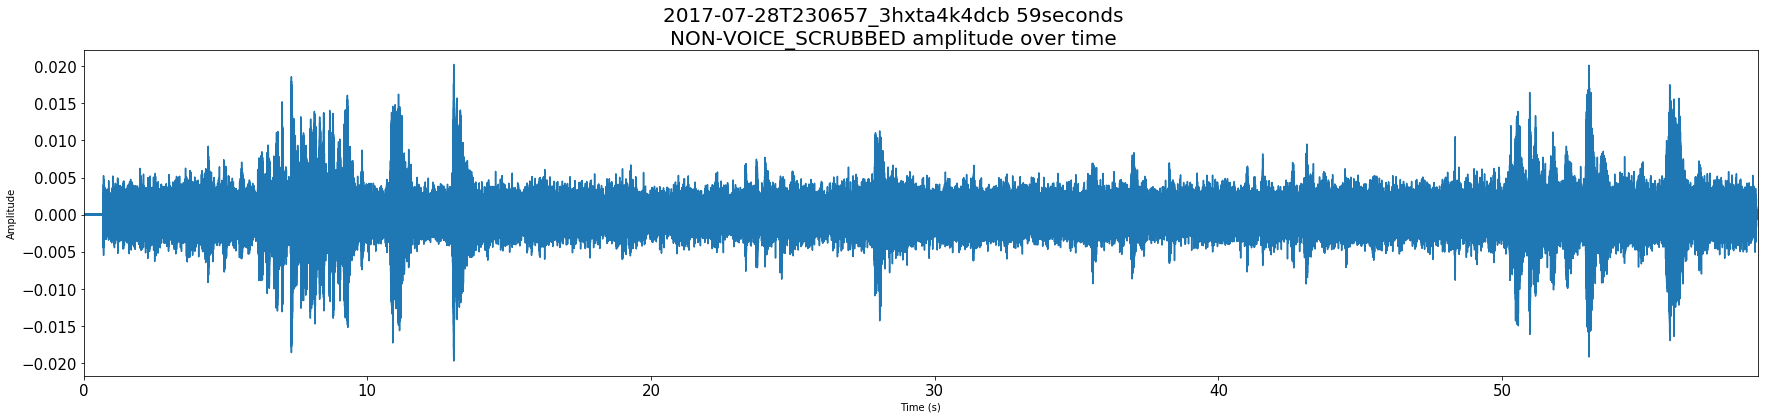

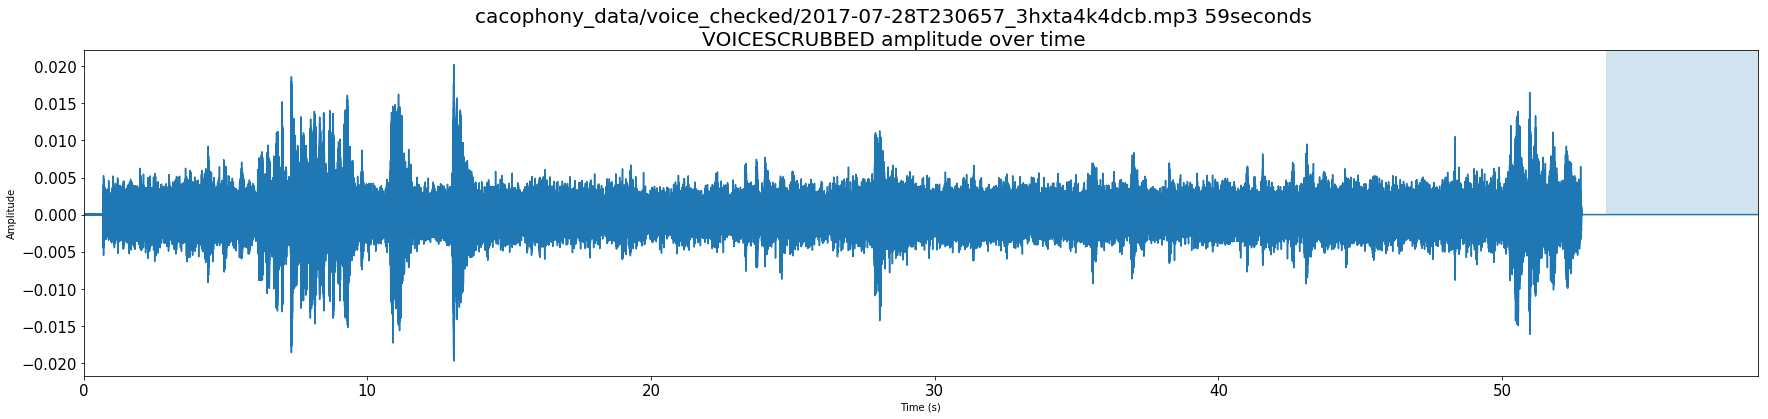


Detecting birds singing

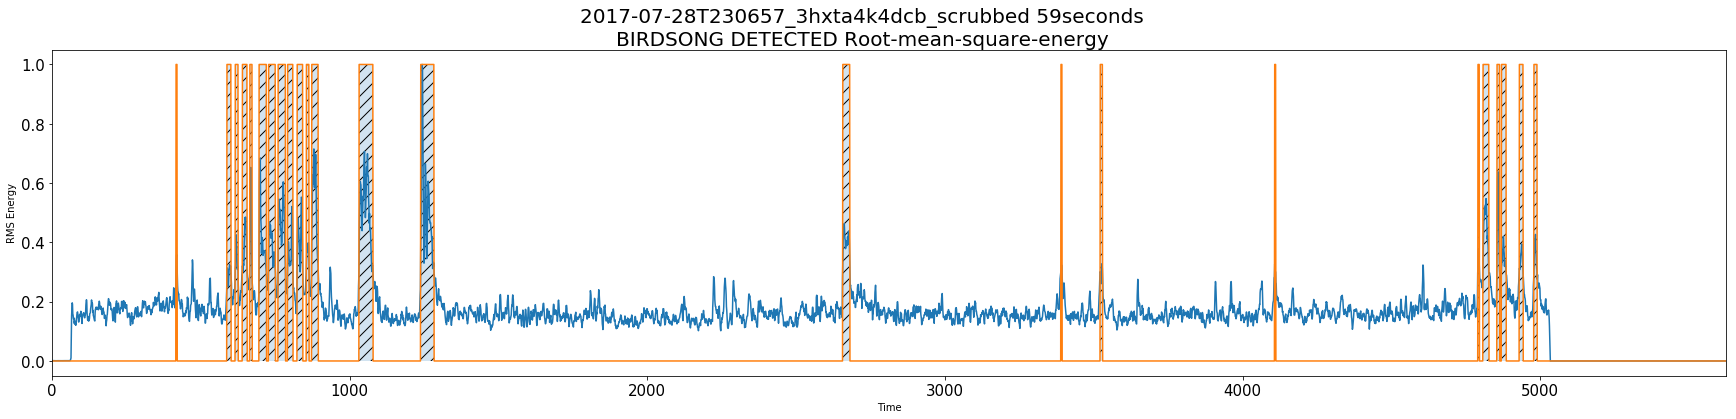

detecting voices
muting voices

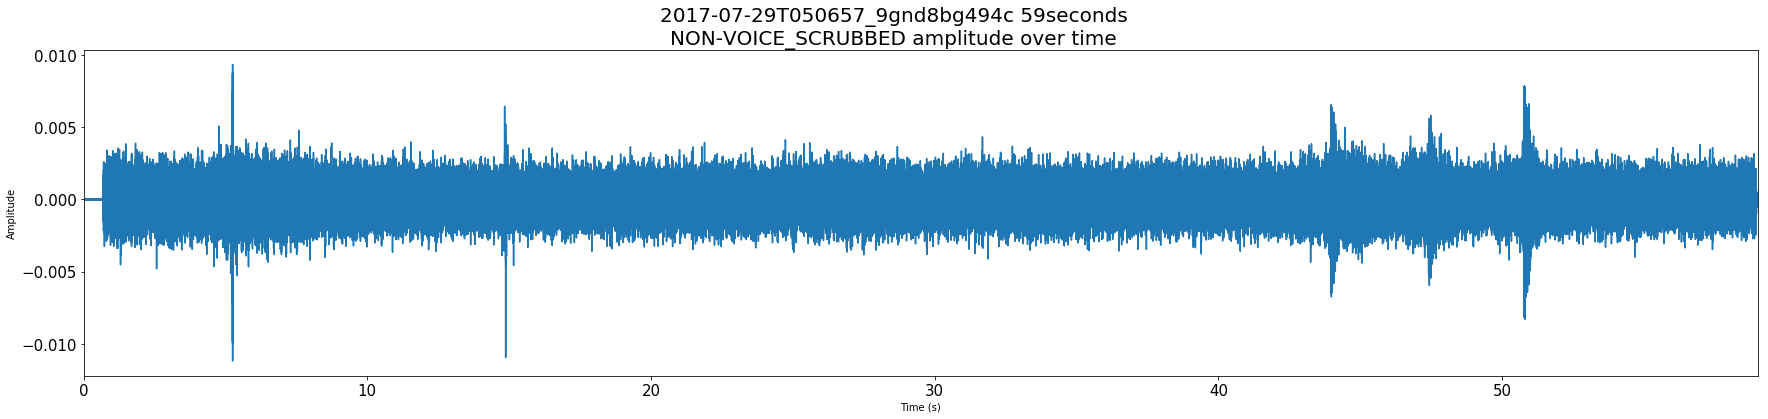

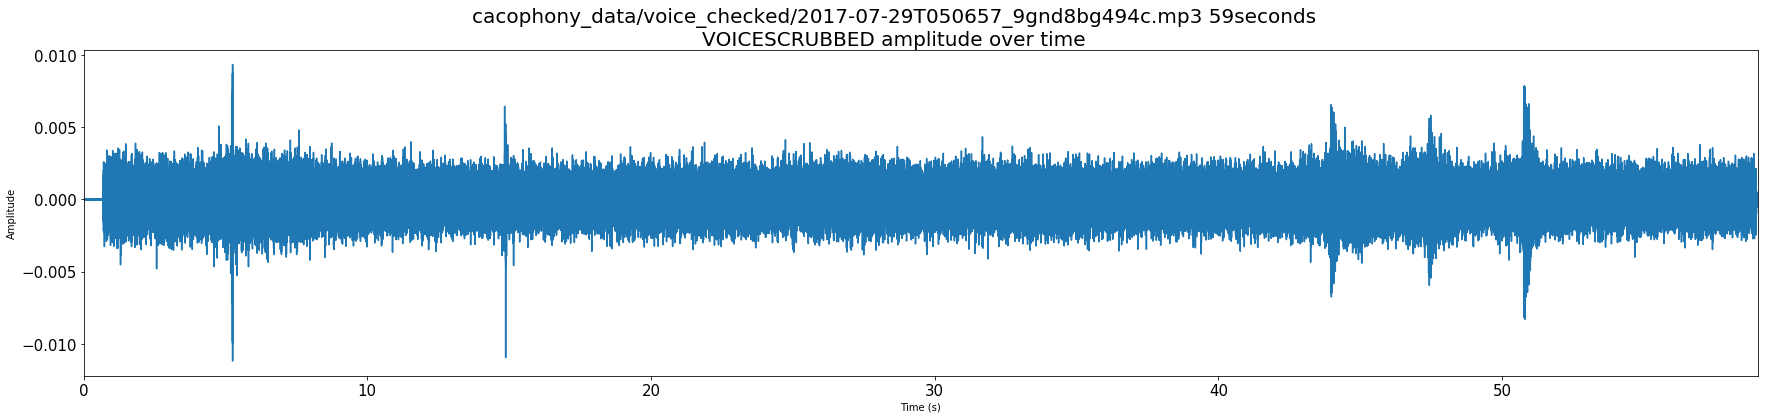


Detecting birds singing

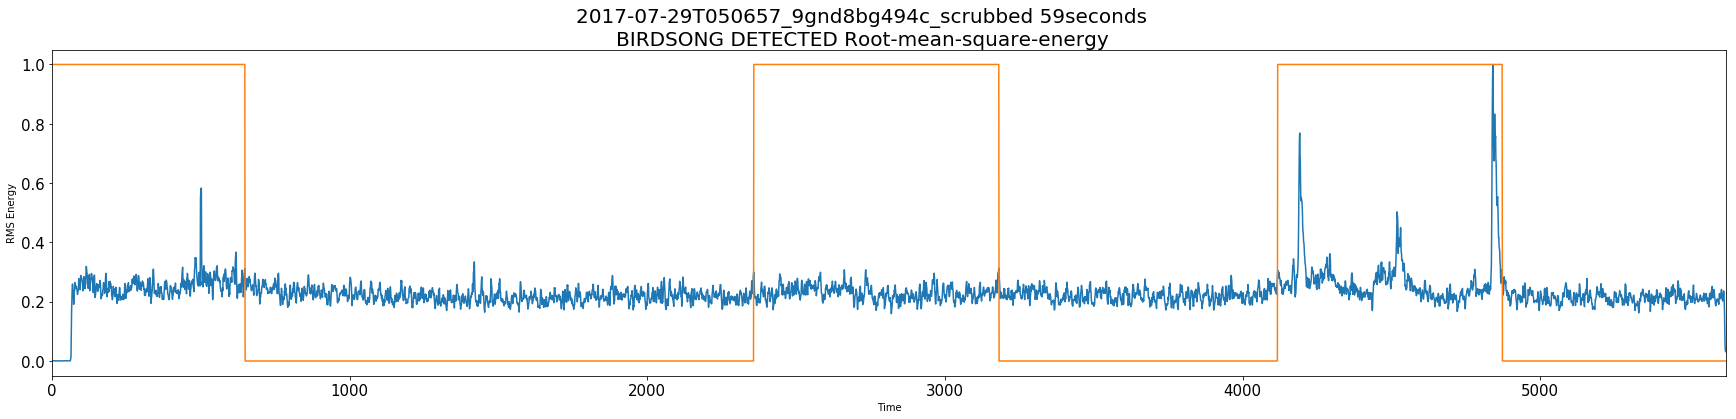

In [9]:
folder = 'cacophony_data/voice_checked/'#change this to the folder of your choice
scores=dict()
save_samples=True
show_plots=True

files = list(list_all_files(folder, ['.mp3', '.wav']))
for path in files:
    basename = os.path.basename(path).split('.')[0] 
    voice_scrubbed_path =  'voice_scrubbed'+ '/' + basename + '_scrubbed' + '.wav'  
    timestamps = detect_voices(path, save_samples=save_samples)
    mute_voices(path, timestamps, show_plots=show_plots)    
    score = detect_events(voice_scrubbed_path, show_plots=show_plots, save_samples=save_samples)
    scores[basename] = score
   

In [ ]:
x=False
if x:
    path = 'sound/data/kea-song.mp3'

    save_samples=True
    show_plots=True

    timestamps = detect_voices(path, save_samples=save_samples)
    mute_voices(path, timestamps, show_plots=show_plots)
    total_event_dur = detect_events(path2, show_plots=show_plots, save_samples=save_samples)

Sometimes you may run out of memory. This is a little tool I've been using to check out what is taking it all up.

In [ ]:
import sys; sorted([(x, sys.getsizeof(globals().get(x))) for x in dir()], key=lambda x: x[1], reverse=True)

I'm currently working on changing the x-axis from 'frames' to time!